# EDA on NLP dataset
The reason for selecting this dataset was to learn about how e-commerce giant does the analysis on the customer reviews to find out which products and category are popular. 

Dataset was part of the amazon polarity dataset which had about about 7 different languages to choose. I went ahead with the English language, by selecting a part of data from the entire dataset created some unexpected challenges.

# Goal 
From the initial dataset exploration, I came to know that there is a single review for each distinct product in every category and there were about 31 different categories of products in the dataset. So, tasks is to find out 

*   Which category is most or least popular from the reviews
*   Try to find which products are popular within category
*   Rank the category to get insight about which category needs improvements
 

#Idealogy or Planning behind the approach
1. Develop wordcloud of each category to find out what customer reviews opinions is about a category. From wordcloud, we can also find some of popular products (e.g. pillow in home category, hair products in beauty category -- *see wordcloud below for more*) within a category.

2. Measuring the polarity of each category to find out which category need more product improvements to increase the sales of the category.

In [ ]:
!pip install datasets
!pip install pandas
!pip install contractions
!pip install spacy
!pip install sklearn
!pip install wordcloud
!pip install textwrap3
!pip install textblob
!pip install seaborn

#Import Libraries

In [ ]:
import contractions
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re 
import string
import spacy
import sklearn
import seaborn as sns




from typing import Text
from datasets import load_dataset
from google.colab import data_table
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from textwrap import wrap
from textblob import TextBlob

data_table.enable_dataframe_formatter()
pd.options.mode.chained_assignment = None  # default='warn'         # Disable the SettingwithCopyWarning --> warning about chain assignment in pandas
pd.set_option('max_rows', 99999)

 

#Dataset Exploration
In the following code blocks we will try to understand the dataset by removing the unnecessary details and plotting the horizontal bar graph which shows the distribution of reviews in each category. From the exploration we find the following:

1.   Entire dataset has 200,000 rows and 8 different columns. *Note: For this notebook we are selecting 90,000 rows due to limitation of resources on Google Colab and to save time.*
2.   Some of the columns from the dataset are removed in part of data pre-processing because they do not provide valuable insight. E.g. Language, Reviewer_id column


 

In [ ]:
dataset = load_dataset("amazon_reviews_multi", "en")                           # Load dataset for amazon reviews in english language
new_df = pd.DataFrame.from_dict(dataset['train'], orient='columns', dtype=None) # Select the train folder dictionary and converting to dataframe
print(' Orginal Dataset Size is :',new_df.shape)                                                             # Orginal dataset shape
exp = new_df.head(90000)                                                       # Select first 90000 rows from 200,000 rows (Amount of data for the analysis can be changed here)
#print(exp)

# Data pre-processing
exp['product_id'] = exp['product_id'].str.strip('product_en_')                  # Keeping only numerical value from the product_id column
del exp['reviewer_id']                                                          # Delete reviewer_id aka user id
del exp['language']                                                             # Delete language column 
del exp['review_id']     
print(exp)                                                     

Reusing dataset amazon_reviews_multi (/root/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

 Orginal Dataset Size is : (200000, 8)
      product_id  ...     product_category
0        0740675  ...            furniture
1        0440378  ...     home_improvement
2        0399702  ...                 home
3        0444063  ...             wireless
4        0139353  ...                   pc
...          ...  ...                  ...
89995    0460776  ...  industrial_supplies
89996    0170754  ...                 home
89997    0526941  ...                 home
89998    0708237  ...                shoes
89999    0834060  ...                shoes

[90000 rows x 5 columns]


# Reviews Distribution

There 31 different categories in which the reviews are distributed. 
*Note: Open image in new tab to view in full-size*

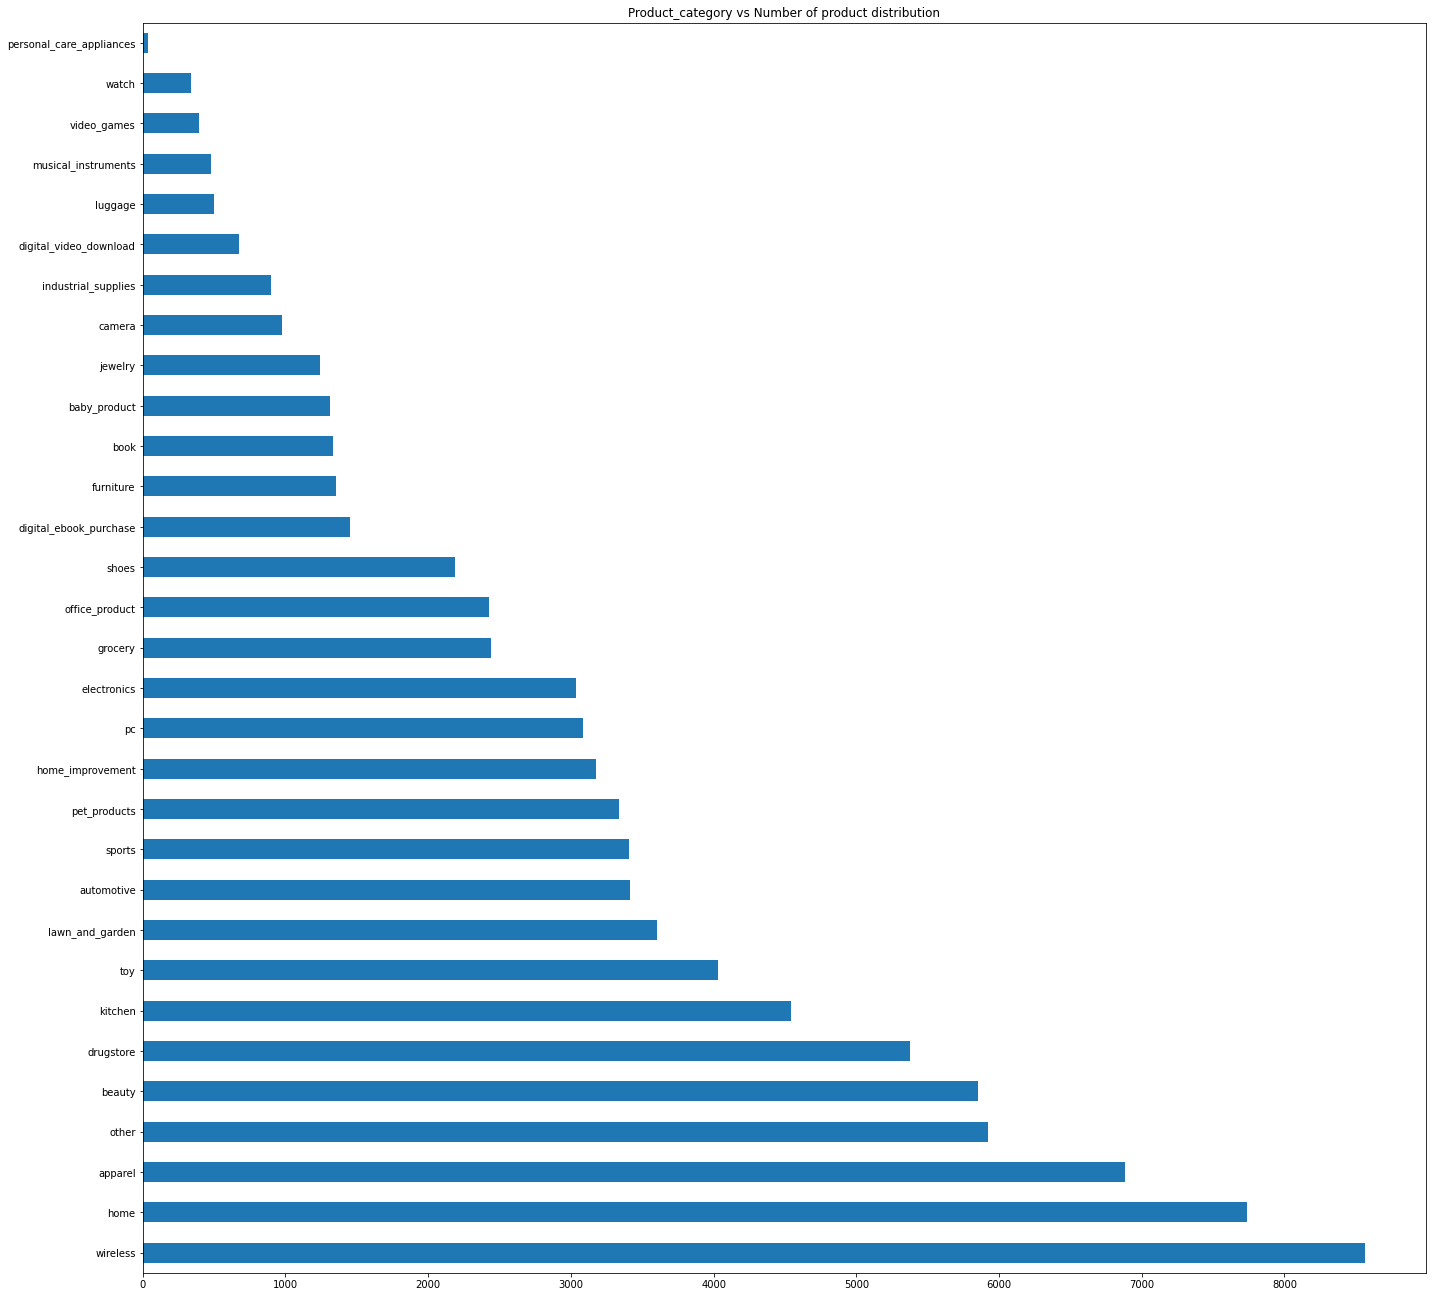

In [ ]:
prod_uniq = exp['product_category'].value_counts()
prod_plot =  prod_uniq.plot(kind="barh",figsize= (23,23), fontsize = 10, title = 'Product_category vs Number of product distribution')   # PLot graph for number of products which are                         
#print(prod_uniq)
#print(exp.product_category.unique())


In [ ]:
print(exp.isnull().sum())    # check there are no null values
print('Number of unique products:', len(exp.product_id.unique()))        #There are 9936 unique products in 100,000 reviews

product_id          0
stars               0
review_body         0
review_title        0
product_category    0
dtype: int64
Number of unique products: 86195


# Data Cleaning 
Data cleaning is required to make sure all the content is same format to get better understanding and insights. Most important column in this dataset is 'review_body' which has detailed review of the product. After taking a quick glance, we found the reviews consists the following :
1. Contractions
2. Capital Letters 
3. Digits and digits in word format
4. Special Characters
5. Punctuation
6. Emojis 😡 😔 😩 🌟

We have to eliminate these to clean and get structured format.


In [ ]:
# Data cleaning

# Remove Contractions
exp['no_contractions'] = exp['review_body'].apply(lambda x: [contractions.fix(word) for word in x.split()])        # converts contractions to normal words but data type is list 
exp['review_body'] = [' '.join(map(str,i)) for i in exp['no_contractions']]
del exp['no_contractions']

# Lowercase reviews
exp['review_body'] = exp['review_body'].apply(lambda x:x.lower())

# Remove digits
exp['review_body'] = exp['review_body'].apply(lambda x:re.sub('\w*\d\w*','',x))

# remove special characters
exp['review_body'] = exp['review_body'].apply(lambda x:re.sub('[@,$]',' ',x))

# remove punctuations
exp['review_body'] = exp['review_body'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

# remove emojis
def remove_emojis(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')                # encode and decode string in ASCII encoding to delete emojis

exp['review_body'] = exp['review_body'].apply(remove_emojis)
exp.head()

product_id  ...  product_category
0    0740675  ...         furniture
1    0440378  ...  home_improvement
2    0399702  ...              home
3    0444063  ...          wireless
4    0139353  ...                pc

[5 rows x 5 columns]

# Preparing text for EDA
Now, we want to refine the 'review_body' to important words which are helpful towards EDA.


*    So, we remove stopwords like 'i','is' which does not add any value and just act connector to form a sentence. This will also reduce the size of the dataset.
*   Also, we perform lemmatization to reduce words to its base form




In [ ]:
model = spacy.load('en_core_web_sm',disable=['parser', 'ner'])              #loading pretrained model from spacy to remove stopwords and to get base form of the word
exp['cleaned_txt'] = exp['review_body'].apply(lambda x: ' '.join([token.lemma_ for token in list(model(x)) if (token.is_stop==False)]))       # apply model on 'review_body' and create new column 'cleaned text'
#exp

In [ ]:
# Group Column to create Document Term Matrix. 
df_group = exp[['product_category','cleaned_txt']].groupby(by ='product_category').agg(lambda x:' '.join(x))    # Grouping according to category (31 categories in total)
cv=CountVectorizer(analyzer='word')
data=cv.fit_transform(df_group['cleaned_txt'])
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index=df_group.index
df_dtm.head(3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


aa  aaa  aaaaa  aaas  aac  ...  zuma  zumba  zwave  zwift  zzzzzzz
product_category                             ...                                    
apparel            0    0      0     0    0  ...     1      1      0      0        0
automotive         1    1      0     0    0  ...     0      0      0      0        0
baby_product       0    0      0     0    0  ...     0      0      0      0        0

[3 rows x 30773 columns]

# EDA based on product category

WordCloud generation is most common way in NLP to get the insight about a particular category. Here, I have tried to do the same for all the 31 categories.
)
From the wordcloud of the the top two and bottom two categories (according to number of reviews) we can tell that:


*   In wireless category, most people buy phone or phone-related product mostly for Iphone. They like the products in this category.
*   In home category, most people like the products they receive, they work and look good.

*  In personal care appliances, there is significant amount of products which are returned. In comparision with other categories it is highest. (Can be seen from the size of the word in the personal care appliance wordcloud)
* In watch category, from the keywords we can say there are some products which are broken and they are returned. Also, this category might have longer delivery or return pick-up time because there is month word amongst the top words.

Overall, in each category there are common words such as 'like', 'work', 'buy', 'product' and 'return' which means they like the products from the amazon and also there is flexible return policy which customers are using on regular basis. 
* *In some categories wordcloud you can also find which products are popular within the particular category. Like pillow in home category, iPhone in wireless category which interesting insight.*

WordCloud gave us a general insight in each category. We can get deeper insight in each category by finding the sentiment of reviews within each category. We will try to do the same in next code block.





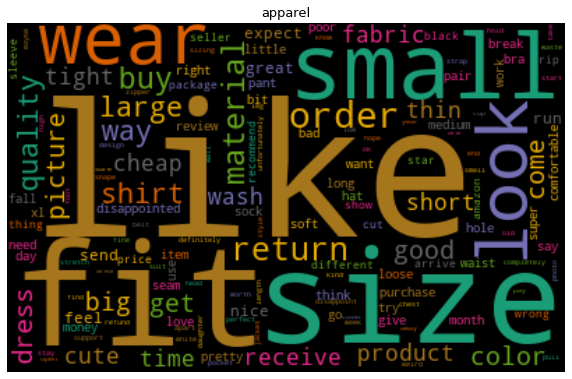

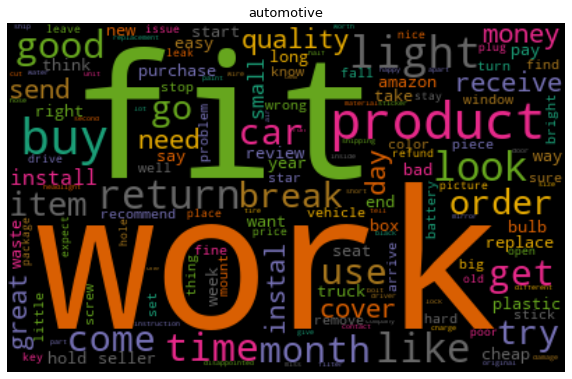

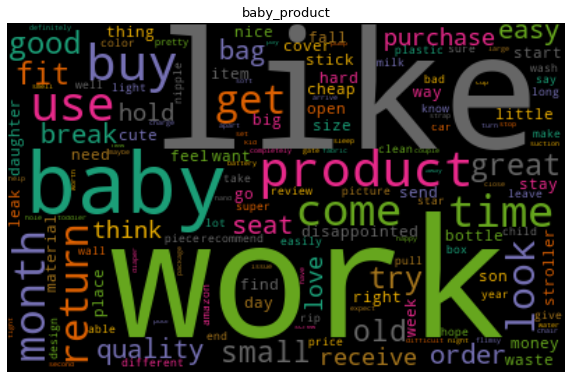

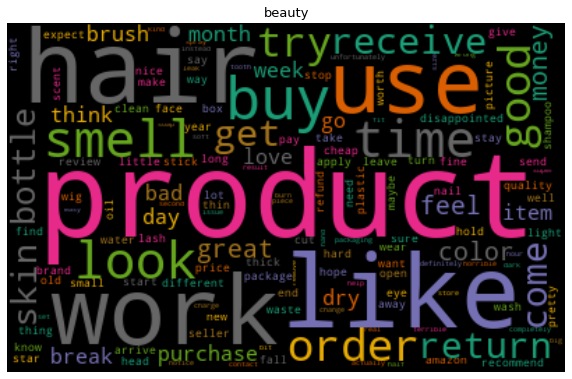

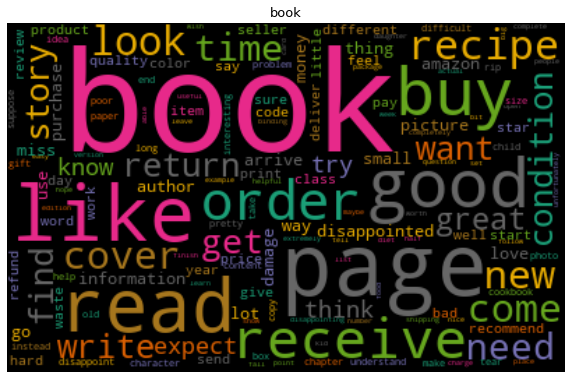

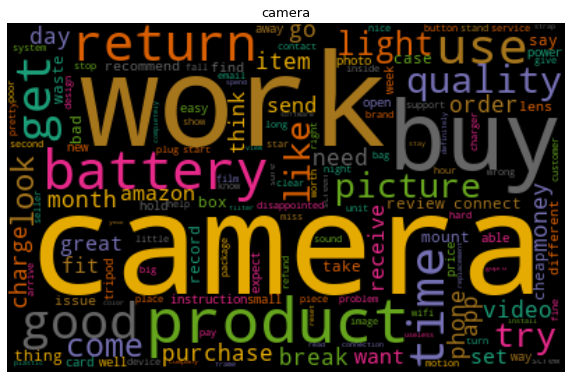

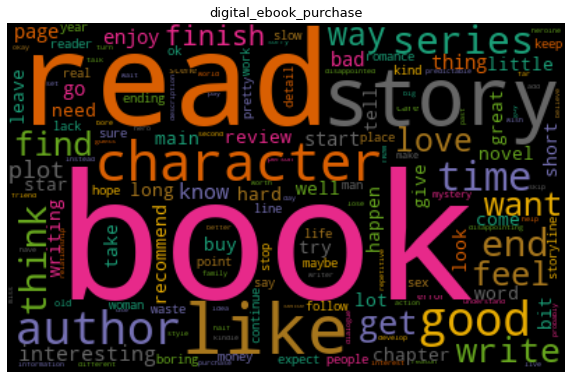

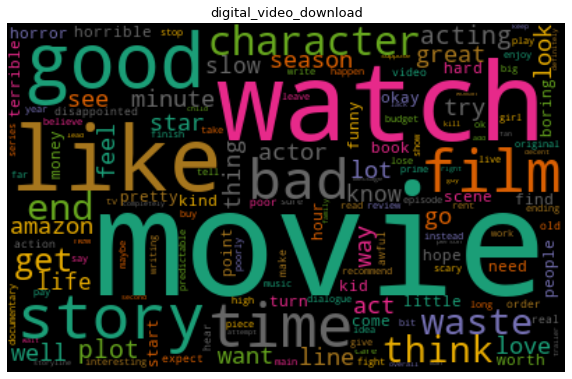

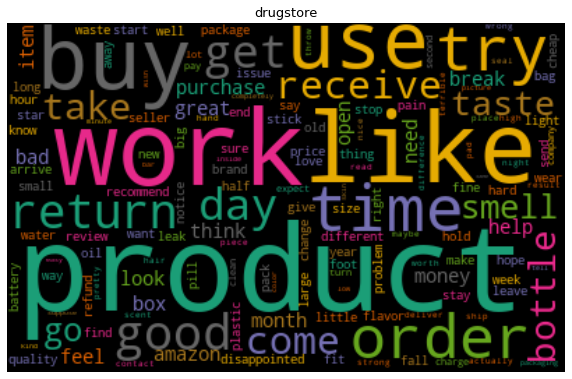

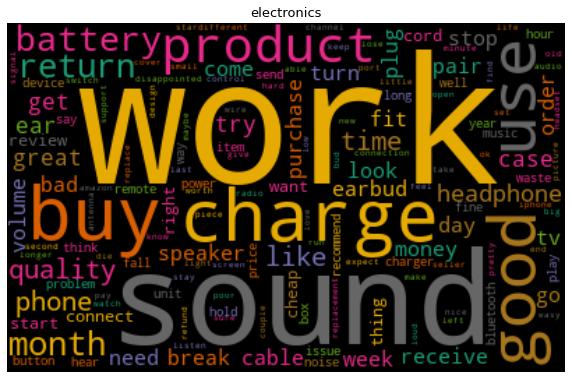

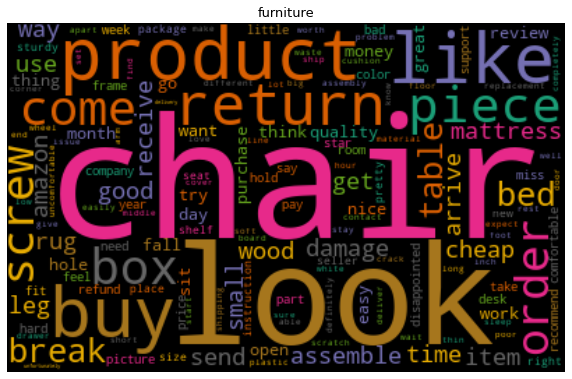

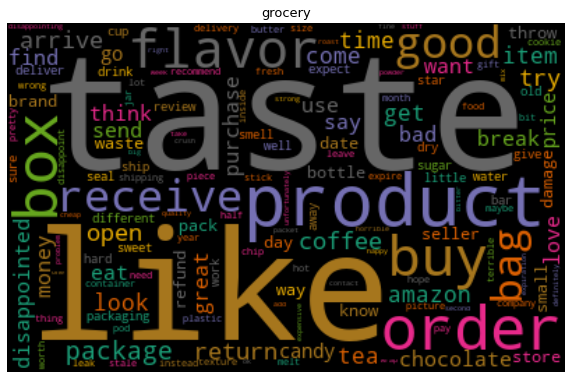

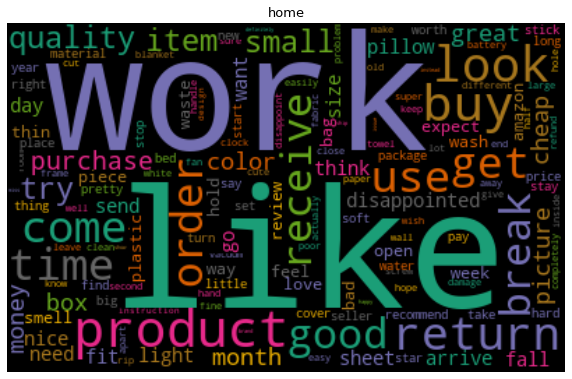

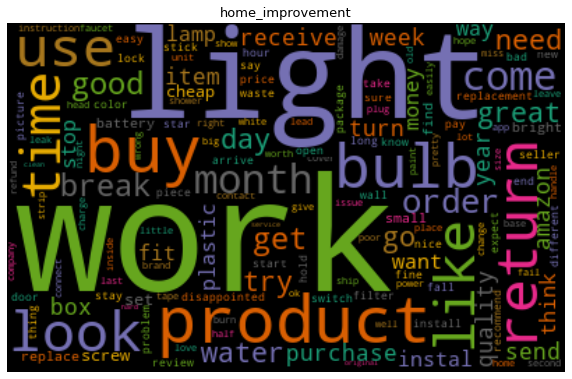

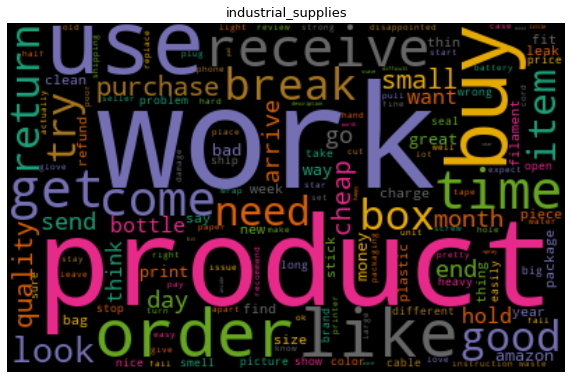

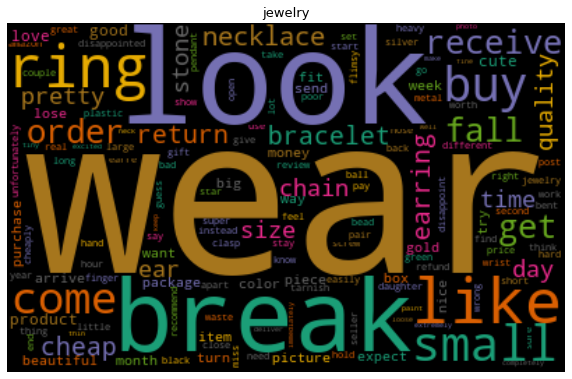

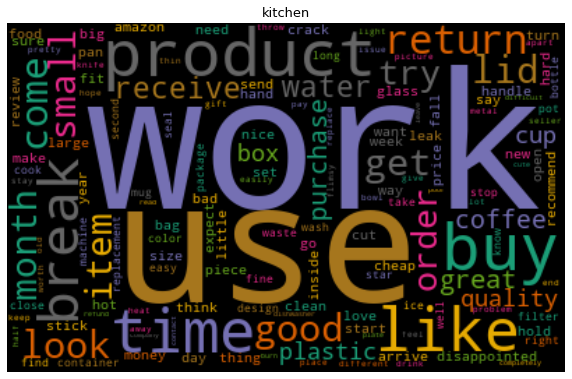

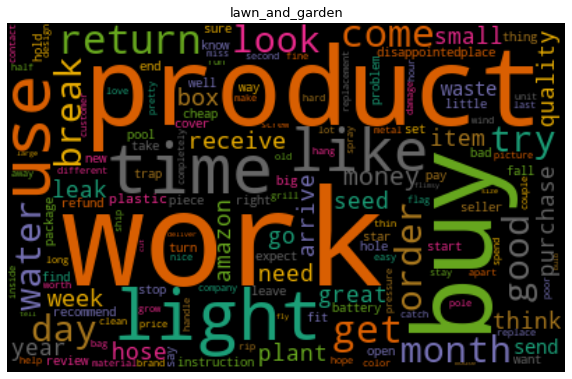

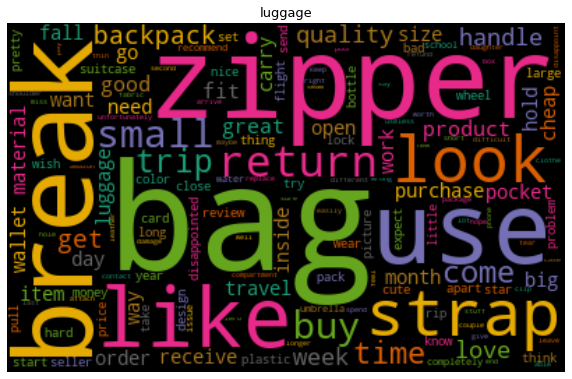

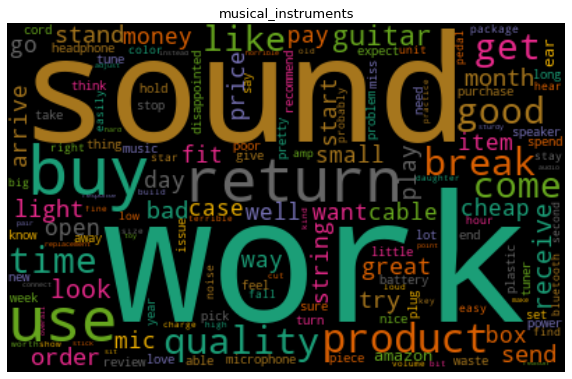

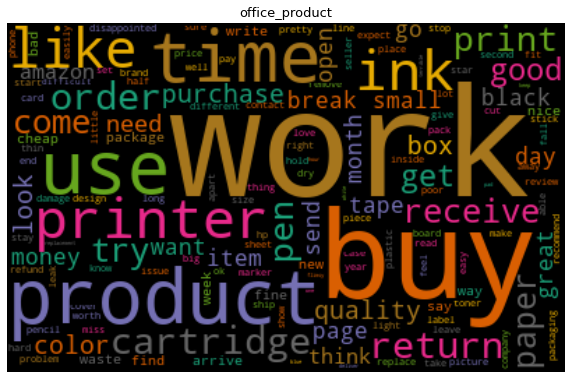

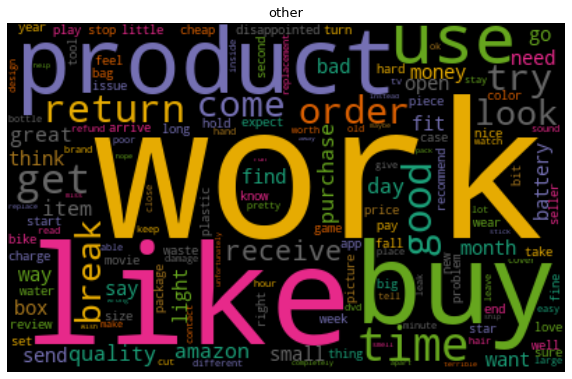

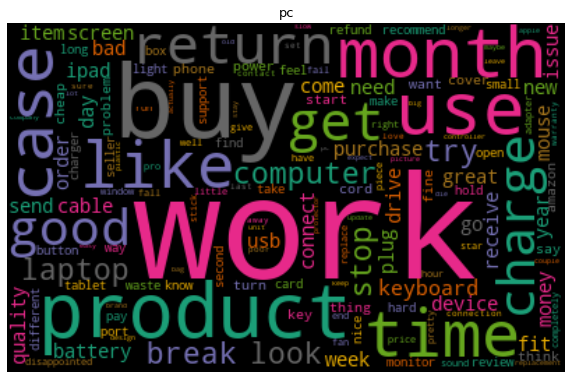

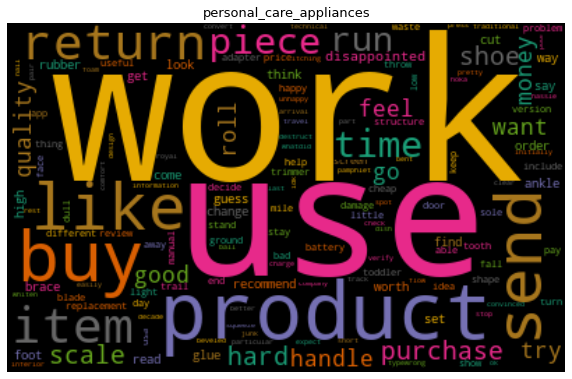

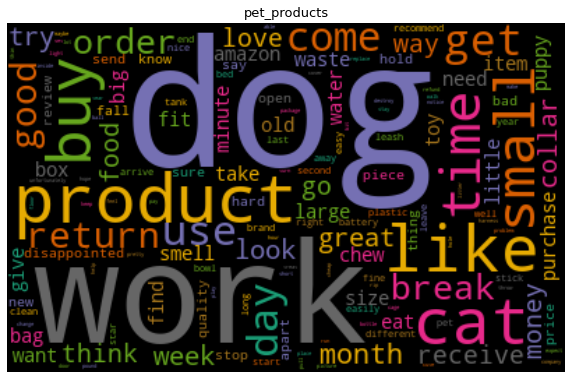

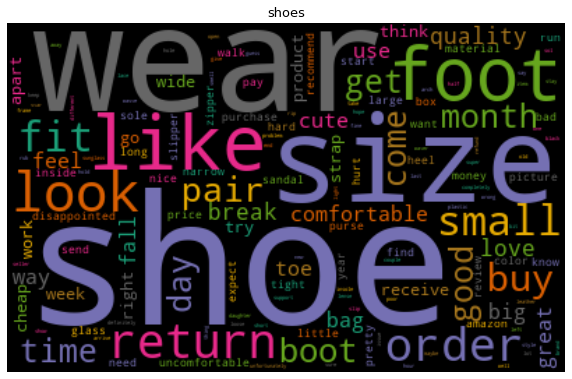

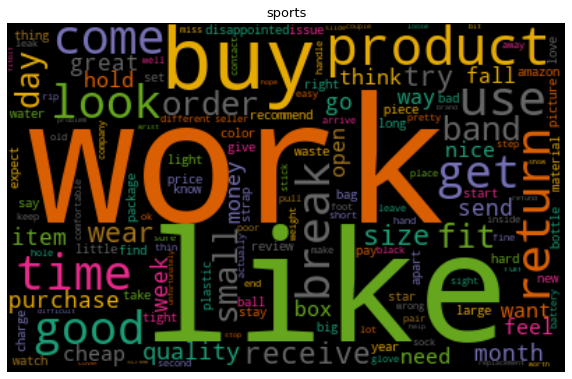

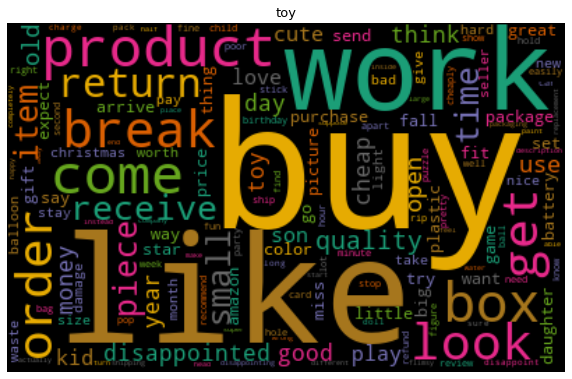

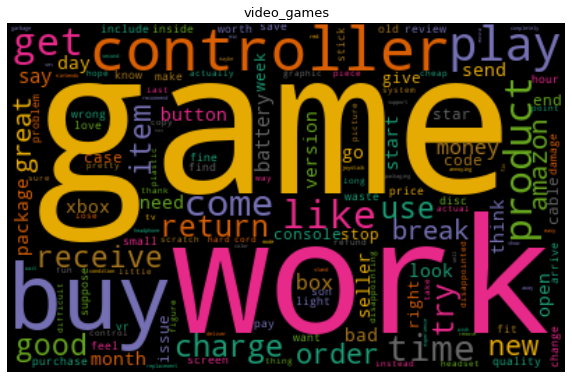

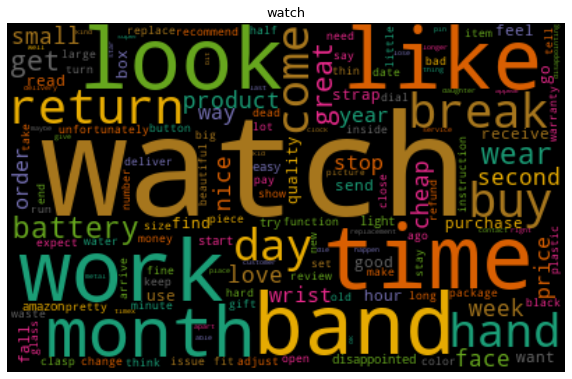

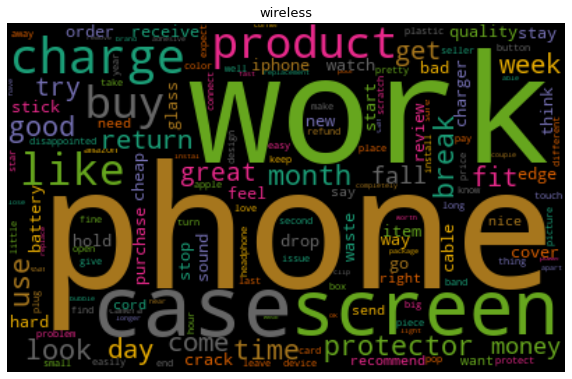

In [ ]:
from wordcloud import WordCloud
from textwrap import wrap

# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=250, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()
  
# Transposing document term matrix
df_dtm=df_dtm.transpose()

# Plotting word cloud for each product
for index,product in enumerate(df_dtm.columns):
  generate_wordcloud(df_dtm[product].sort_values(ascending=False),product)

From the polarity we can find which category products need improvements and vice versa. When the polarity is towards positive one means the product category is doing well. If the polarity is negative then its needs serious improvements to increase the sales. 

From the plot below, we can see that Video Games and digital video download categories have negative polarities which means product in this categories are not good. Whereas, Jewelry, automative are doing good in comparision with the other categories.

Also, interesting insight which is observed is polarity is independent of the number of reviews in each category.For instancce, automotive and home improvement has moderate amount of reviews within the dataset but their polarity is high on the positive side. This perspective of insight is only true within the bounds of the current dataset and is possible for variation depends on new reviews. 

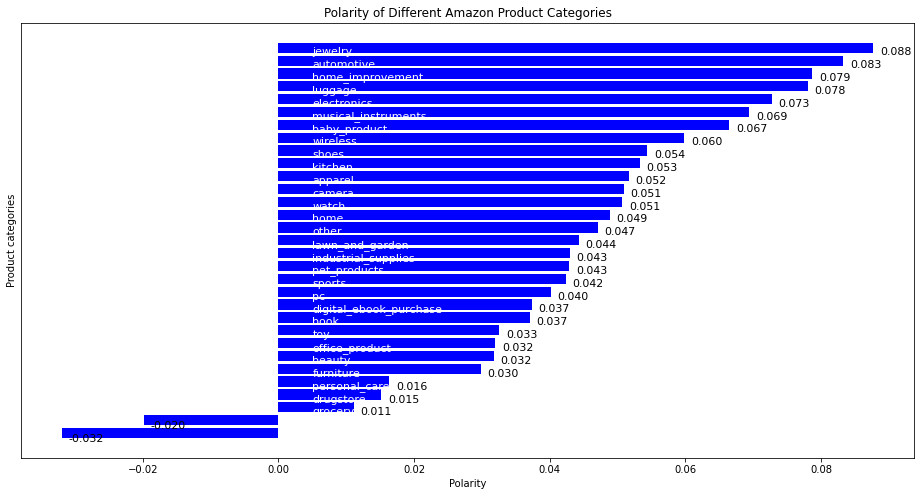

In [ ]:
exp['polarity']=exp['cleaned_txt'].apply(lambda x:TextBlob(x).sentiment.polarity)           # calculating the polarity based on the 'cleaned_txt' column and saving to 'polarity'
polarity_sorted=pd.DataFrame(exp.groupby('product_category')['polarity'].mean().sort_values(ascending=True))      # Sorting polarity data based on product category

plt.figure(figsize=(16,8))
plt.xlabel('Polarity')
plt.ylabel('Product categories')
plt.title('Polarity of Different Amazon Product Categories')
polarity_graph=plt.barh(np.arange(len(polarity_sorted.index)),polarity_sorted['polarity'],color='Blue',)

# Writing product names on bar
for bar,product in zip(polarity_graph,polarity_sorted.index):
  plt.text(0.005,bar.get_y()+bar.get_width(),'{}'.format(product),va='center',fontsize=11,color='white')

# Writing polarity values on graph
for bar,polarity in zip(polarity_graph,polarity_sorted['polarity']):
  plt.text(bar.get_width()+0.001,bar.get_y()+bar.get_width(),'%.3f'%polarity,va='center',fontsize=11,color='black')
  
plt.yticks([])
plt.show()

# Challenges Faced
1. Dataset has only one review for each product which creates diversity in the dataset and diffucult to predict popular products in the category.
2. Reviews distribution amongst the categories is also not uniform this leads to new challenge.

Every data has story to tell if worked on it properly and patiently. Thank you for opportunity.

